# Classification using Random Forest

In this chapter we will be using the Random Forest implementation provided by the `scikit-learn` library. Scikit-learn is an amazing machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including NumPy, SciPy, and matplotlib, which makes it very easy to incorporate into your workflow. The number of available methods for accomplishing any task contained within the library is (in my opinion) its real strength. No single algorithm is best for all tasks under all circumstances, and scikit-learn helps you understand this by abstracting the details of each algorithm to simple consistent interfaces.

This following figure shows the classification predictions and the decision surfaces produced for three classification problems using 9 different classifiers.

<img src="https://scikit-learn.org/0.15/_images/plot_classifier_comparison_0011.png">

credit : https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

In [1]:
import glob, os, time
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import features

import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from pathlib import Path
from IPython.display import display

print(f'Numpy : {np.__version__}')
print(f'Pandas : {pd.__version__}')
print(f'GeoPandas : {gpd.__version__}')
print(f'Scikit-learn: {sklearn.__version__}')

Numpy : 1.19.2
Pandas : 1.1.5
GeoPandas : 0.8.1
Scikit-learn: 0.24.1


## Set paths for input and output directories

Create directories if there are missing using `Path` and `mkdir`

In [2]:
# Set the general input and output paths
# --------------------------------------

# When you are connected to the computer room
'''
grp_letter   = 'X'
student_name = 'ndeffense'

vector_path = 'X:/data/VECTOR/'
raster_path = 'X:/data/RASTER/'
output_path = f'X:/GROUP_{grp_letter}/TP/{student_name}/DATA/'
'''

# When you are connected to your personnal computer
vector_path = '/Users/Nicolas/OneDrive - UCL/LBRAT2104/VECTOR/'
raster_path = '/Volumes/nbdid-sst-lbrat2104/data/RASTER/'
output_path = '/Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/'


print(f'Vector input path are set to : {vector_path}')
print(f'Raster input path are set to : {raster_path}')
print(f'Output path are set to       : {output_path}')

# Directory to store all classification outputs
classif_path = f'{output_path}CLASSIF/'

Path(classif_path).mkdir(parents=True, exist_ok=True)

Vector input path are set to : /Users/Nicolas/OneDrive - UCL/LBRAT2104/VECTOR/
Raster input path are set to : /Volumes/nbdid-sst-lbrat2104/data/RASTER/
Output path are set to       : /Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/


## Preparing the dataset

### Rasterize in-situ data shapefile


In [4]:
# Set up filenames

in_situ_cal_shp = f'{output_path}IN_SITU/WALLONIA_2018_IN_SITU_ROI_cal.shp'
in_situ_cal_tif = f'{output_path}IN_SITU/WALLONIA_2018_IN_SITU_ROI_cal.tif'
img_temp_tif = f'{output_path}IM_ROI/T31UFR_20200316T104709_B02_10m_ROI.tif'


# Open the shapefile with GeoPandas

in_situ_gdf = gpd.read_file(in_situ_cal_shp)

# Open the raster file you want to use as a template for rasterize

img_src = rasterio.open(img_temp_tif)
img     = img_src.read()

meta = img_src.meta.copy()
meta.update(compress='lzw')
meta.update(nodata=0)

# Burn the features into the raster and write it out

dst_src = rasterio.open(in_situ_cal_tif, 'w+', **meta)
dst_arr = dst_src.read(1)

# this is where we create a generator of geom, value pairs to use in rasterizing

geom_col = in_situ_gdf.geometry
code_col = in_situ_gdf.CODE

shapes = ((geom,value) for geom, value in zip(geom_col, code_col))


in_situ_cal_arr = features.rasterize(shapes=shapes,
                                     fill=0,
                                     out=dst_arr,
                                     transform=dst_src.transform)

dst_src.write_band(1, in_situ_cal_arr)

# Close rasterio objects

img_src.close()
dst_src.close()


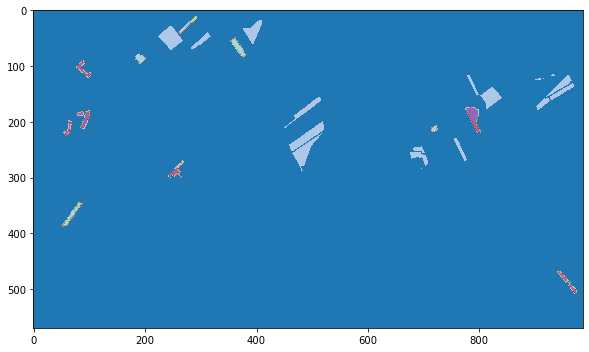

In [5]:
# Plot images

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.imshow(in_situ_cal_arr, cmap='tab20')

plt.tight_layout()

## List all the classification features

In this case, one NDVI per month

In [8]:
# Get list of all files containing the features
list_img = sorted(glob.glob(f'{output_path}NDVI_ROI/T31UFS_*_NDVI_10m_ROI_SCL.tif'))

# Create an empty list to append all feature rasters one by one
list_arr = []

for img_file in list_img:

    # Open feature raster
    img_src = rasterio.open(img_file)
    img = img_src.read(1)

    # Add it in the list
    list_arr.append(img)

# Merge all the 2D matrices from the list into one 3D matrix
feat_arr = np.dstack(list_arr)

print(feat_arr.shape)
print(f'There are {feat_arr.shape[2]} features')

(570, 986, 12)
There are 12 features


### Pairing Y with X

Now that we have the image we want to classify (our X feature inputs), and the ROI with the land cover labels (our Y labeled data), we need to pair them up in NumPy arrays so we may feed them to Random Forest.

In [12]:
# Find how many non-zero entries we have -- i.e. how many training data samples?

n_samples = (in_situ_cal_arr > 0).sum()

print(f'We have {n_samples} samples\n')


# What are our classification labels?
labels = np.unique(in_situ_cal_arr[in_situ_cal_arr > 0])
print(f'The training data include {labels.size} classes: {labels} \n')


# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = feat_arr[in_situ_cal_arr > 0, :]
y = in_situ_cal_arr[in_situ_cal_arr > 0]

print(f'Our X matrix is sized: {X.shape}')
print(f'Our y array is sized: {y.shape}')


We have 42175 samples

The training data include 25 classes: [   6    9   12   19   20   21   36   45   62   73   91  201  311  321
  342  541  542  821  901  931 4111 9410 9741 9742 9812] 

Our X matrix is sized: (42175, 12)
Our y array is sized: (42175,)


## Training the Random Forest

Now that we have our X matrix of feature inputs (the NDVI for each month) and our y array (the labels), we can train our model.

Visit this <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html" target="_blank">web page</a>  to find the usage of RandomForestClassifier from scikit-learn.

In [13]:
start_training = time.time()

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

end_training = time.time()

# Get time elapsed during the Random Forest training
hours, rem = divmod(end_training-start_training, 3600)
minutes, seconds = divmod(rem, 60)
print("Random Forest training : {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Random Forest training : 00:00:53.71


With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [14]:
print(f'Our OOB prediction of accuracy is: {round(rf.oob_score_ * 100,2)}%')


Our OOB prediction of accuracy is: 98.32%


To help us get an idea of which features bands were important, we can look at the feature importance scores:

In [16]:
bands = range(1,X.shape[1]+1)

for b, imp in zip(bands, rf.feature_importances_):
    print(f'Band {b} importance: {round(imp,4)}')

Band 1 importance: 0.0681
Band 2 importance: 0.0295
Band 3 importance: 0.0831
Band 4 importance: 0.1027
Band 5 importance: 0.0885
Band 6 importance: 0.0746
Band 7 importance: 0.0935
Band 8 importance: 0.0983
Band 9 importance: 0.1087
Band 10 importance: 0.0875
Band 11 importance: 0.0894
Band 12 importance: 0.0761


Let's look at a crosstabulation to see the class confusion

In [17]:

# Setup a dataframe
df = pd.DataFrame()

df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions

cross_tab = pd.crosstab(df['truth'], df['predict'], margins=True)

display(cross_tab)


predict,6,9,12,19,20,21,36,45,62,73,...,542,821,901,931,4111,9410,9741,9742,9812,All
truth,,,,,,,,,,,,,,,,,,,,,
6,3795,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3795
9,0,72,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72
12,0,0,93,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,93
19,0,0,0,2806,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2806
20,0,0,0,0,473,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,473
21,0,0,0,20,0,295,0,0,0,0,...,0,0,0,0,0,0,0,0,0,315
36,0,0,0,0,0,0,2490,0,0,0,...,0,0,0,0,0,0,0,0,0,2490
45,0,0,0,0,0,0,0,896,0,0,...,0,0,0,0,0,0,0,0,0,896
62,0,0,0,0,0,0,0,0,3233,0,...,0,0,0,0,0,0,0,0,0,3233


## Predicting the rest of the image

With our Random Forest classifier fit, we can now proceed by trying to classify the entire image.

In [18]:
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification

img = feat_arr

new_shape = (img.shape[0] * img.shape[1], img.shape[2])

img_as_array = img[:, :, :].reshape(new_shape)

print(f'Reshaped from {img.shape} to {img_as_array.shape}')


start_classification = time.time()

# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

end_classification = time.time()

hours, rem = divmod(end_classification-start_classification, 3600)
minutes, seconds = divmod(rem, 60)
print("Random Forest training : {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Reshaped from (570, 986, 12) to (562020, 12)
Random Forest training : 00:01:29.64


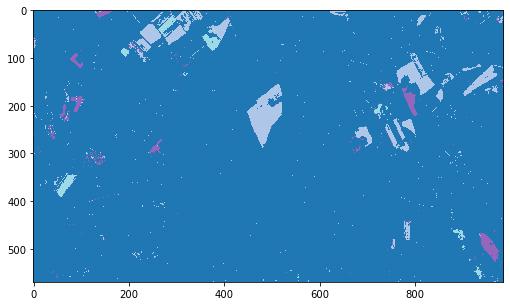

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.imshow(class_prediction, cmap='tab20', interpolation='none')


In [20]:
classif_tif = f'{classif_path}classif_ROI.tif'

print(class_prediction.shape)

img_src = rasterio.open(img_temp_tif)
img = img_src.read()

meta = img_src.meta.copy()
meta.update(compress='lzw')

print(meta)


dst = rasterio.open(classif_tif, 'w', **meta)

dst.write(class_prediction, 1)

dst.close()

(570, 986)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 986, 'height': 570, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 627260.0,
       0.0, -10.0, 5596180.0), 'compress': 'lzw'}


## Validation